In [44]:
import os
import cv2
import pandas
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

### Sample NAE Dataset Annotations
```
IMG_2012-09-26T09-00-01.jpg
4640,3132,17,15,u
4882,3158,16,24,u
707,3273,23,19,u
IMG_2012-09-26T09-00-03.jpg
5218,3156,32,24,b
IMG_2012-09-26T09-00-05.jpg
5528,3106,38,27,b
4139,3164,28,21,b
691,3258,35,19,b
516,3319,21,28,b
5272,3146,31,29,b
IMG_2012-09-26T09-00-07.jpg
5552,3140,29,15,b
1167,3164,40,25,u
```

In [10]:
## Data Array for Checking Much Later
processed_annotations = []

## Labels
labels = ['Drones', 'Birds', 'Aircrafts']

## Average Bounding Box Size
avg_width   = 0
avg_height  = 0
avg_area    = 0
class_birds = 0
class_aircraft = 0

In [13]:
def ConvertNAEAnnotations(filename, img_path, output_filename):
    # Image Extensions List
    image_extensions = ['.jpg', '.JPG', '.png', '.PNG', '.jpeg', '.JPEG']
    # Open File
    annotation_data = open(filename, "r")
    output_file     = open(output_filename, "w")
    
    # Current Filename
    curr_filename = None
    curr_height   = None
    curr_width    = None
    
    # Class Index Variable
    class_idx = None
    
    # Statistics Tracking
    global avg_width
    global avg_height
    global avg_area
    global class_birds
    global class_aircraft
    
    for line in annotation_data:
        # Check for Filename
        if any(extension in line for extension in image_extensions):
            curr_filename = line.rstrip()
            # Obtain Dimensions
            try:
                # Check if File Exists
                im = Image.open(img_path + curr_filename)
                if im is None:
                    continue
            except:
                # Debugger
                print(curr_filename + " does not exist.")
                continue
            
                
            curr_width, curr_height = im.size
        else:
            # Parse Data for Pre-processing
            x_min, y_min, height, width, obj = line.rstrip().split(",")
            
            # Record Statistics
            avg_width  += int(width)
            avg_height += int(height)
            avg_area   += int(width) * int(height)
            
            x_min = int(x_min)
            y_min = int(y_min)
            x_max = x_min + int(width)
            y_max = y_min + int(height)
            
            x_min_norm = x_min / curr_width
            y_min_norm = y_min / curr_height
            x_max_norm = x_max / curr_width
            y_max_norm = y_max / curr_height
            
            # Convert Class Name
            if obj is 'b':
                class_idx = 2
                class_birds += 1
            elif obj is 'u':
                class_idx = 3
                class_aircraft += 1
            
            # Write and Record
            processed_annotations.append((curr_filename, class_idx, x_min_norm, y_min_norm, x_max_norm, y_max_norm))
            output_file.write("{} {} {} {} {} {}\n".format(curr_filename, class_idx, x_min_norm, y_min_norm, x_max_norm, y_max_norm))
            
    # Close Files
    annotation_data.close()
    output_file.close()
            
            

In [14]:
ConvertNAEAnnotations("../data/bird_annotation/bird_annotation.txt",  "../data/bird_images/", "annotation.txt")

### Check Random Bounding Boxes 
```
1. Randomly select various images
2. Render bounding boxes
3. Inspect
4. Profit
```

Processing : IMG_2012-09-26T09-02-35.jpg
1338 2790 31 30


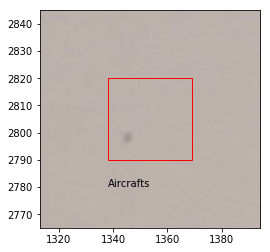

In [88]:
import random
import matplotlib.patches as patches

def check_random_img(padding, img_filename=None, bbox_data=None):
    # Use Random Index
    if img_filename is None:
        rand_idx = random.randint(0, len(processed_annotations))
        # Extract Tuple
        curr_filename, class_idx, x_min_norm, y_min_norm, x_max_norm, y_max_norm = processed_annotations[rand_idx] 
        image_file_path = "../data/bird_images/" + curr_filename
    else:
        image_file_path = img_filename
        curr_filename, class_idx, x_min_norm, y_min_norm, x_max_norm, y_max_norm = bbox_data
    
    print("Processing : " + curr_filename)

    # Read Image File
    img = cv2.imread(image_file_path)
    height, width, channels = img.shape
    fig, ax = plt.subplots(1)

    bbox_left   = int(width  * x_min_norm)
    bbox_top    = int(height * y_min_norm)
    bbox_width  = int((x_max_norm - x_min_norm) * width)
    bbox_height = int((y_max_norm - y_min_norm) * height)
    plt.text(bbox_left, bbox_top - 10, labels[class_idx - 1])
    
    print(bbox_left, bbox_top, bbox_width, bbox_height)
    
    # Create a Rectangle patch
    rect = patches.Rectangle((bbox_left, bbox_top), bbox_width, bbox_height, linewidth=1, edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
    plt.xlim(bbox_left - padding, bbox_left + bbox_width + padding)
    plt.ylim(bbox_top - padding, bbox_top + bbox_height + padding)
    
    
    # Add the patch to the Axes
    ax.imshow(img)
    plt.show()

check_random_img(25)

### Check for Mean Bounding Box Size and Distribution
Analyze Bounding Box Distributions

In [30]:
print("Average Width  : {}".format(int(avg_width / len(processed_annotations))))
print("Average Height : {}".format(int(avg_height / len(processed_annotations))))
print("Birds          : {}\nAircrafts      : {}".format(class_birds, class_aircraft))

Average Width  : 26
Average Height : 35
Birds          : 10611
Aircrafts      : 4796


### Convert Images to Bounding Box Padded Crops
The image resolution in the bird datasets are too large in comparison with the actual objects that are bounded.

In [96]:
import PIL
import hashlib
from PIL import Image

def crop_around_bb(padding):
    # Augmented Annotations File
    output_file = open("../data/augmented_annotations/annotations.txt", "w")
    
    # Iterate Through All Data
    for data in tqdm(processed_annotations):
        curr_filename, class_idx, x_min_norm, y_min_norm, x_max_norm, y_max_norm = data
        image_file_path = "../data/bird_images/" + curr_filename
        
        # Load Image
        img           = Image.open(image_file_path)
        width, height = img.size
        
        # Perform Random Padding
        pad_top    = random.randint(0, padding)
        pad_left   = random.randint(0, padding)
        pad_right  = random.randint(0, padding)
        pad_bottom = random.randint(0, padding)
        
        bbox_left    = int(width  * x_min_norm)
        bbox_top     = int(height * y_min_norm)
        bbox_width   = int((x_max_norm - x_min_norm) * width)
        bbox_height  = int((y_max_norm - y_min_norm) * height)
        
        crop_dim = (bbox_left - pad_left, bbox_top - pad_top, bbox_left + bbox_width + pad_right, bbox_top + bbox_height + pad_bottom)
        crop_img = img.crop(crop_dim)
        img_hash = hashlib.md5(crop_img.tobytes()).hexdigest()
        augmented_filename = img_hash + ".png"
        crop_img.save("../data/augmented_birds/" + augmented_filename)
        
        # Recalculate Bounding Boxes Coordinates
        crop_height  = pad_top + pad_bottom + bbox_height
        crop_width   = pad_left + pad_right + bbox_width
        bbox_x_min   = pad_left / crop_width
        bbox_y_min   = pad_top / crop_height
        bbox_x_max   = (pad_left + bbox_width)  / crop_width
        bbox_y_max   = (pad_top + bbox_height) / crop_height
        
        #check_random_img(25, "../data/augmented_birds/" + augmented_filename, (augmented_filename, class_idx, bbox_x_min, bbox_y_min, bbox_x_max, bbox_y_max))
        
        output_file.write("{} {} {} {} {} {}\n".format(augmented_filename, class_idx, bbox_x_min, bbox_y_min, bbox_x_max, bbox_y_max))
       
    # Close Output File
    output_file.close()

# Execute
crop_around_bb(150)

In [7]:
random_map = {1 : 1, 2 : 2, 3 : 3}
list(random_map)[2:]

[3]